In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Import my modules
sys.path.append('../modules') # Path to modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg
from preprocess_dataframes import combine_ivt_ar_prec_df, df_annual_clim, calculate_ivt_prec_percentiles, df_AR_annual_clim, df_AR_precip_contribution

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs


prec_clim, prec_std = df_annual_clim(df_lst, community_lst, varname='prec') # get precipitation annual climatology
ivt_clim, ivt_std = df_annual_clim(df_lst, community_lst, varname='IVT') # get IVT annual climatology

# some cleaning for the dfs for the annual clim fig
prec_clim['month'] = prec_clim.index.values - 1
prec_melt = pd.melt(prec_clim, id_vars='month')

ivt_clim['month'] = ivt_clim.index.values - 1
ivt_melt = pd.melt(ivt_clim, id_vars='month')

ar_clim = df_AR_annual_clim(df_lst, community_lst, varname='AR') # get AR annual climatology

cross_tab = df_AR_precip_contribution(df_lst, community_lst, varname='prec') # contribution to annual precip

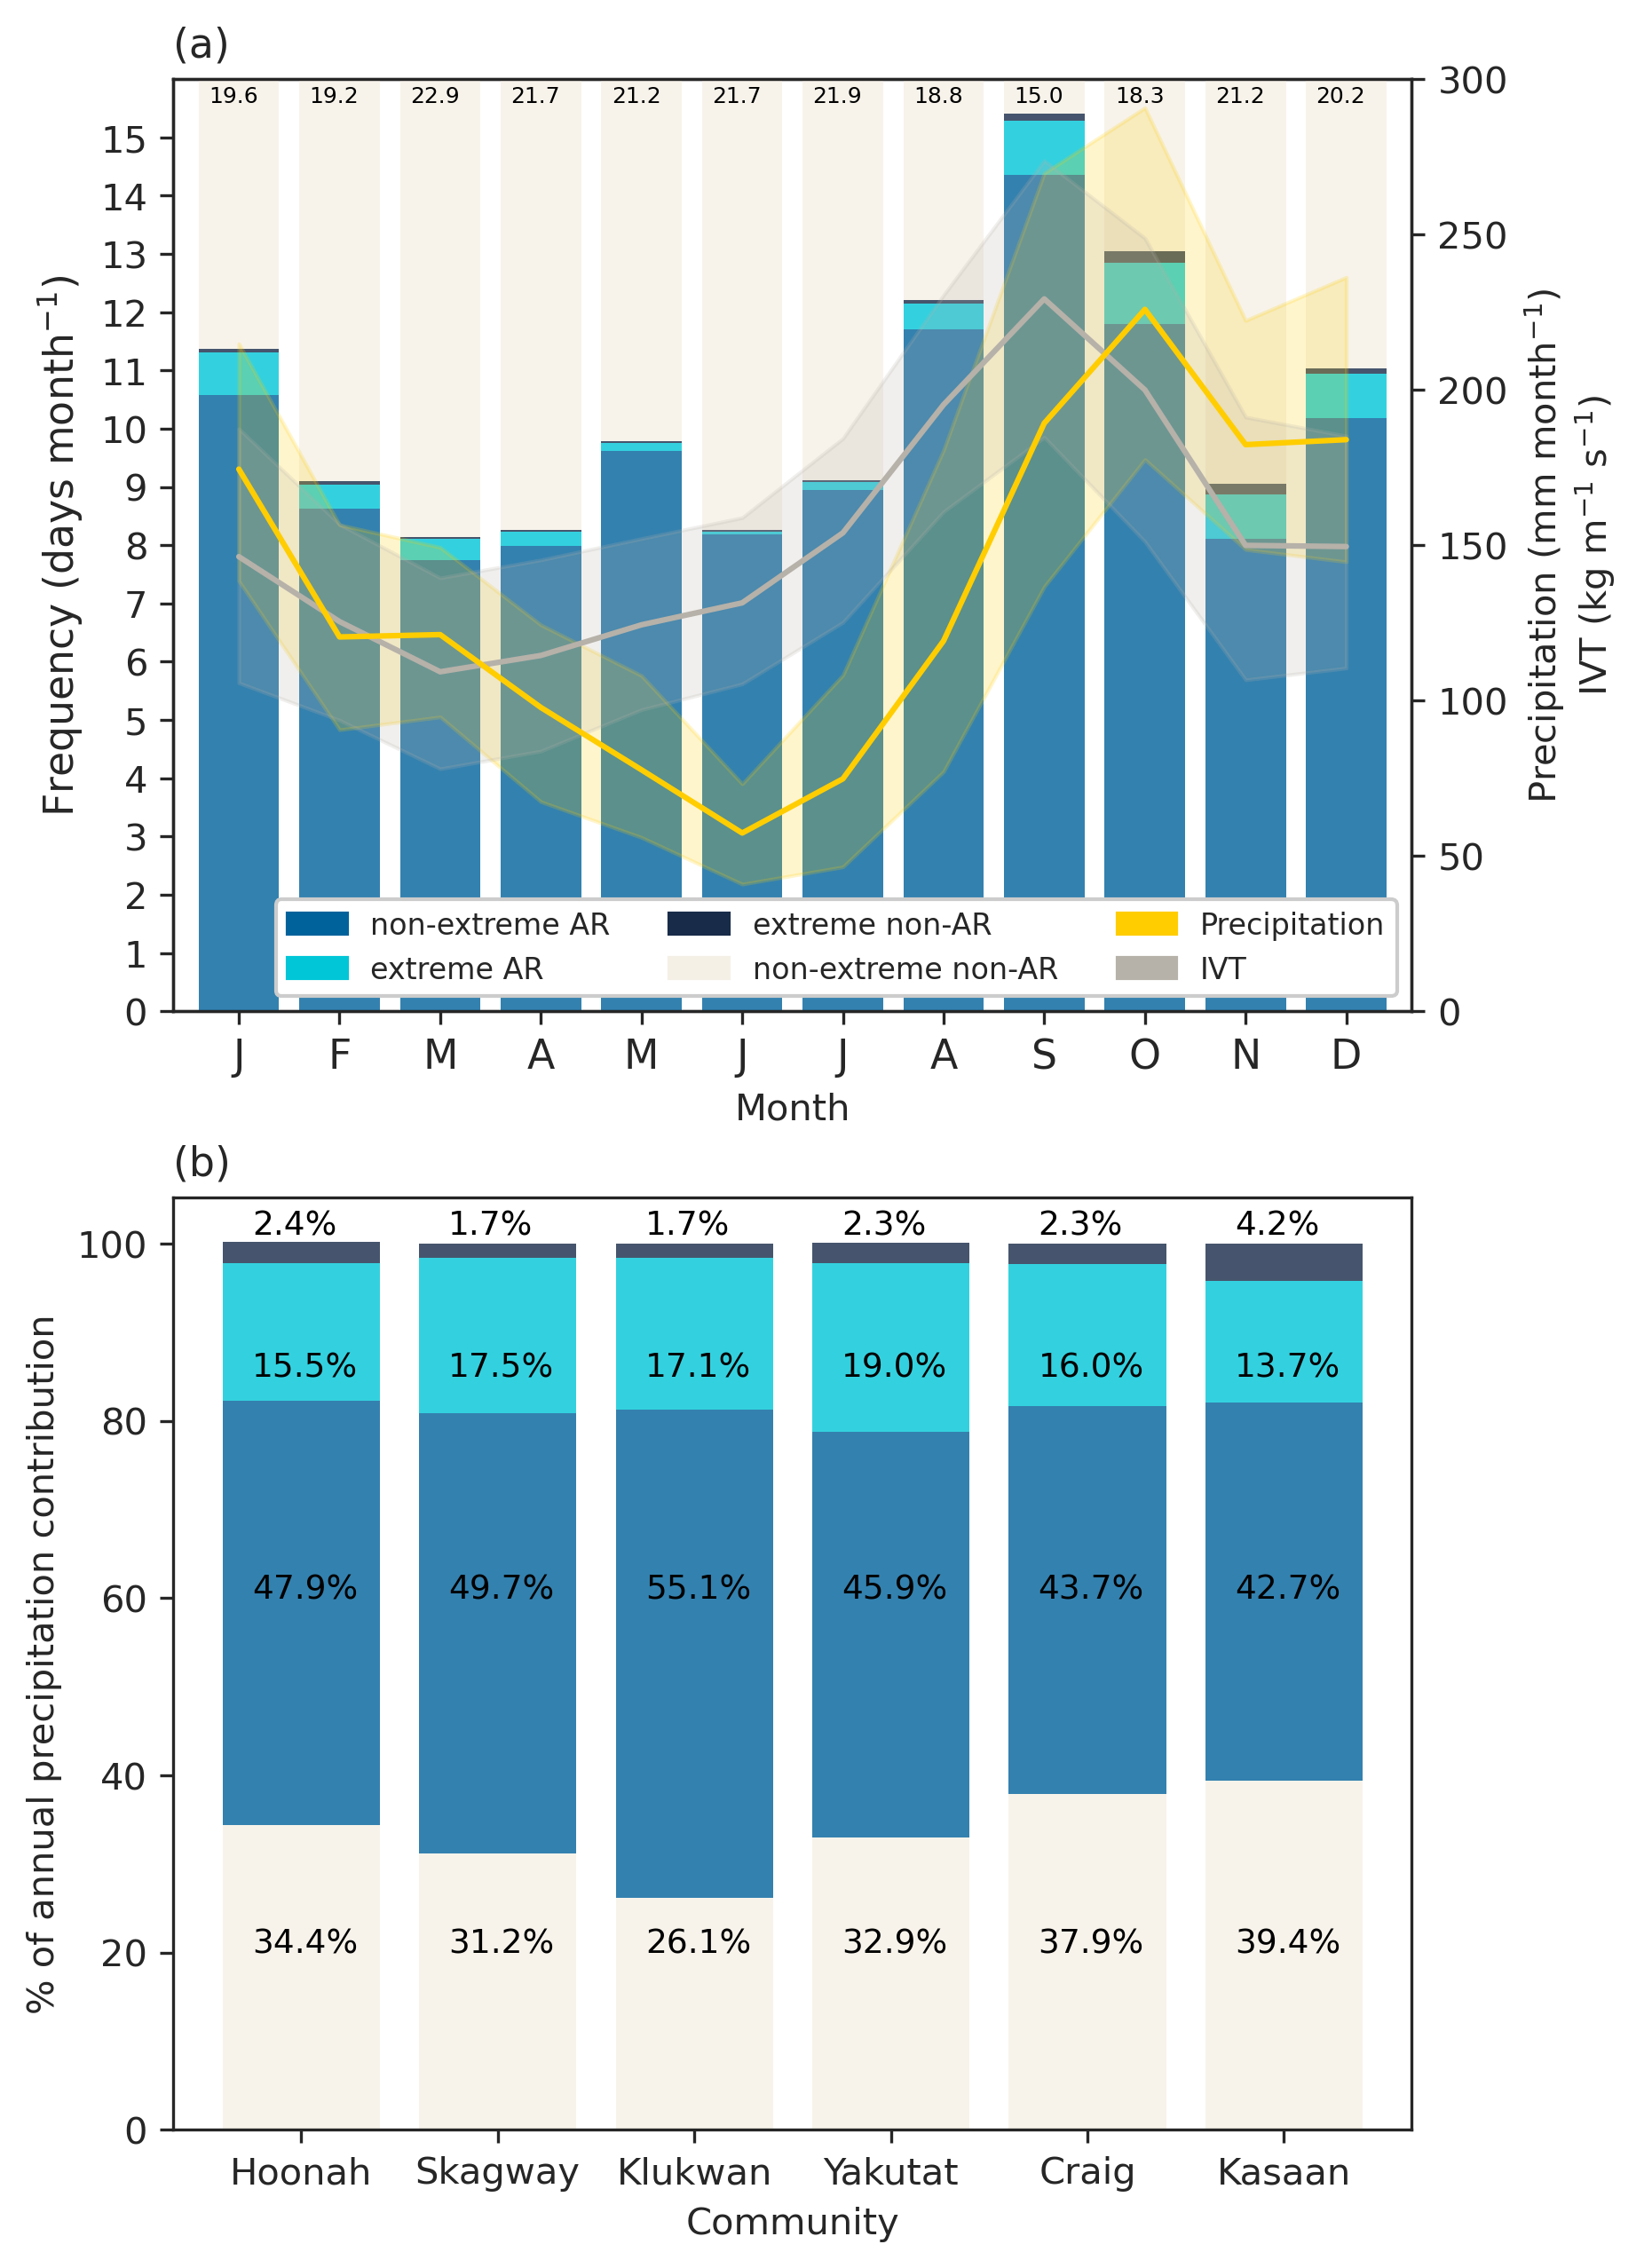

In [4]:
fname = path_to_figs + 'ar_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((6.0,10.0))
fig.dpi = 300

# Set custom color palette
colors = ["#00629B"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
# sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_style('ticks')
sns.despine()

ax = fig.add_subplot(2, 1, 1)
## bar plot with AR clim
g = ar_clim.plot(kind = 'bar', stacked = True, color=[ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy'], ucsd_colors['sand']], 
             alpha=0.8, zorder=10, ax=ax, rot='horizontal', legend=False, linewidth=0., width=0.8)
ax.set_ylabel('Frequency (days month$^{-1}$)', fontsize=11)
ax.set_xlabel('Month', fontsize=10)
ax.set_xticklabels(columns, fontsize=11)
ax.set_yticks(np.arange(0, 16, 1))
ax.set_ylim(0, 16)

xloc = np.arange(0, 13, 1)
yloc = 15.6
proportion = ar_clim['non-AR non-extreme'].values
for i, (x, prop) in enumerate(zip(xloc, proportion)):
  
    plt.text(x=x-0.3,
             y=yloc,
             s=f'{np.round(prop, 1)}', 
             color="black",
             fontsize=6,
             fontweight="light", zorder=200)

plt.legend([],[], frameon=False)
ax.set_title('(a)', fontsize=11, loc='left')

## add twin axis for ivt
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

## line plot with precip clim
prec = sns.lineplot(data=prec_melt, x="month", y="value", ax=ax2, color=ucsd_colors['yellow'], zorder=101) # plots community spread
## line plot with ivt clim
ivt = sns.lineplot(data=ivt_melt, x="month", y="value", ax=ax2, color=ucsd_colors['stone'], zorder=100) # plots community spread
ax2.set_yticks(np.arange(0, 325, 50))
ax2.set_ylim(0, 300)
lbl = 'Precipitation (mm month$^{-1}$) IVT (kg m$^{-1}$ s$^{-1}$)'
ax2.set_ylabel(textwrap.fill(lbl, 32), fontsize=10)

# create legend (of the 3 classes)
patch0 = mpatches.Patch(color=ucsd_colors['blue'], label='non-extreme AR')
patch1 = mpatches.Patch(color=ucsd_colors['aqua'], label='extreme AR')
patch2 = mpatches.Patch(color=ucsd_colors['navy'], label='extreme non-AR')
patch3 = mpatches.Patch(color=ucsd_colors['sand'], label='non-extreme non-AR')
patch4 = mpatches.Patch(color=ucsd_colors['yellow'], label='Precipitation')
patch5 = mpatches.Patch(color=ucsd_colors['stone'], label='IVT')
ax2.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], loc='lower right', framealpha=1.0, ncol=3, fontsize=8).set_zorder(200)

    
### Second row plot
ax3 = fig.add_subplot(2, 1, 2)
cross_tab.plot(kind = 'bar', stacked = True, color=[ucsd_colors['sand'], ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy']], alpha=0.8,
               rot='horizontal', ax=ax3, linewidth=0., width=0.8)

# plt.legend(loc="lower right", ncol=2)
plt.xlabel("Community")
plt.ylabel("% of annual precipitation contribution")

yloc_new = np.tile([20, 60, 85, 101], (6, 1))
for n, x in enumerate([*cross_tab.index.values]):
    for i, (proportion, y_loc) in enumerate(zip(cross_tab.loc[x],
                                   cross_tab.loc[x].cumsum())):
  
        plt.text(x=n - 0.25,
                 y=yloc_new[n, i],
                 s=f'{np.round(proportion, 1)}%', 
                 color="black",
                 fontsize=9,
                 fontweight="light")
    
plt.legend([],[], frameon=False)
ax3.set_title('(b)', fontsize=11, loc='left')

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [5]:
prec_min = 2.5 # mm per day
ndays_prec = []
ndays_AR = []
npercent_AR_annual = []
ndays_prec_extreme = []
ndays_prec_extreme_AR = []
npercent_AR_extreme = []

## some information on AR contribution
for i, df in enumerate(df_lst):
    print('On average in {0}...'.format(community_lst[i]))
    # number of days per year with precipitation > prec_min
    nyears = float(len(df.index.year.unique())) 
    x = df['prec'].count() / nyears
    print('...there are {0} days per year with precipitation greater than {1} mm per day'.format(x, prec_min))
    ndays_prec.append(x)
    
    # number of AR days per year
    idx = (df.AR == 1)
    tmp = df.loc[idx]
    ar_days = len(tmp) / nyears
    print('...there are {0} AR days per year'.format(ar_days))
    ndays_AR.append(ar_days)
    
    # AR contribution to total annual precipitation
    ## (total annual precip during AR days / total annual precip) * 100
    prec_clim = df.prec.groupby(df.index.year).sum() # get total precipitation per year
    ar_prec_clim = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during ARs
    ar_contr = (ar_prec_clim / prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to total annual precipitation'.format(avg_ar_contr))
    npercent_AR_annual.append(avg_ar_contr)
    
    # number of days per year where precipitation is "extreme" > 95th percentile
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    idx = (df['extreme'] == 1)
    extreme_count = len(df.loc[idx])
    x = extreme_count / nyears
    print(u'...there are {:.2f} days per year with precipitation greater than {:.2f} mm per day'.format(x, prec_thres))
    ndays_prec_extreme.append(x)
    
    ## number of AR days with extreme precipitation
    idx = (df.AR == 1) & (df['extreme'] == 1)
    tmp = df.loc[idx]
    ar_days_extreme = len(tmp) / nyears
    print('...{0} of which are AR days'.format(ar_days_extreme))
    ndays_prec_extreme_AR.append(ar_days_extreme)
    
    ## AR contribution to extreme precipitation
    ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
    extreme_prec = df.loc[(df['extreme'] == 1)]
    extreme_prec_clim = extreme_prec.prec.groupby(extreme_prec.index.year).sum() # get total precipitation during extreme events
    ar_prec_clim_extreme = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during extreme ARs
    ar_contr = (ar_prec_clim_extreme / extreme_prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to extreme precipitation'.format(avg_ar_contr))
    npercent_AR_extreme.append(avg_ar_contr)
    

On average in Hoonah...
...there are 147.85 days per year with precipitation greater than 2.5 mm per day
...there are 122.575 AR days per year
...ARs contribute 63.00% to total annual precipitation
...there are 7.40 days per year with precipitation greater than 27.25 mm per day
...6.475 of which are AR days
...ARs contribute 87.19% to extreme precipitation
On average in Skagway...
...there are 117.225 days per year with precipitation greater than 2.5 mm per day
...there are 122.575 AR days per year
...ARs contribute 66.92% to total annual precipitation
...there are 5.88 days per year with precipitation greater than 31.46 mm per day
...5.3 of which are AR days
...ARs contribute 91.58% to extreme precipitation
On average in Klukwan...
...there are 91.7 days per year with precipitation greater than 2.5 mm per day
...there are 122.575 AR days per year
...ARs contribute 71.79% to total annual precipitation
...there are 4.60 days per year with precipitation greater than 28.89 mm per day
...4

In [6]:
d = {'# of prec days': ndays_prec, '# of AR days': ndays_AR,
     '% of annual prec AR': npercent_AR_annual, '# days extreme prec': ndays_prec_extreme,
     '# days extreme prec': ndays_prec_extreme, '# days extreme prec AR': ndays_prec_extreme_AR,
     '% of extreme prec AR': npercent_AR_extreme}

stats_df = pd.DataFrame(d, index=community_lst)

In [7]:
stats_df

,# of prec days,# of AR days,% of annual prec AR,# days extreme prec,# days extreme prec AR,% of extreme prec AR
Hoonah,147.85,122.58,63.00,7.40,6.47,87.19
Skagway,117.22,122.58,66.92,5.88,5.30,91.58
Klukwan,91.70,122.58,71.79,4.60,4.17,92.59
Yakutat,166.45,122.58,64.42,8.32,7.33,87.84
Craig,145.40,122.58,59.56,7.28,6.30,86.02
Kasaan,141.25,122.58,56.06,7.08,5.38,74.57


In [8]:
stats_df.describe()

,# of prec days,# of AR days,% of annual prec AR,# days extreme prec,# days extreme prec AR,% of extreme prec AR
count,6.00,6.00,6.00,6.00,6.00,6.00
mean,134.98,122.58,63.63,6.76,5.83,86.63
std,26.43,0.00,5.52,1.32,1.10,6.45
min,91.70,122.58,56.06,4.60,4.17,74.57
25%,123.23,122.58,60.42,6.17,5.32,86.31
50%,143.32,122.58,63.71,7.18,5.84,87.52
75%,147.24,122.58,66.30,7.37,6.43,90.65
max,166.45,122.58,71.79,8.32,7.33,92.59
